In [3]:
# !pip install colorama 
# !pip install kaggle
# !mkdir ~/.kaggle
# # download your kaggle API key and upload it to this colabd session
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
# # mount your google drive
# %cd /content/drive/MyDrive/dataset/CatsDogs
# !kaggle competitions download -c dogs-vs-cats
# %cd ~

baseDir = "/content/drive/MyDrive/dataset/CatsDogs"
dataDir = "/content/data"
# !cp /content/drive/MyDrive/dataset/CatsDogs/train.zip /content/data/
# !cp /content/drive/MyDrive/dataset/CatsDogs/test1.zip /content/data/

![cats_dogs](catsdogs.jpg)

## **Table of Contents**

1. Introduction
2. Loading data
3. Data visualization
4. Classification with Vanila CNN
5. Data agumentaion, learning rate schedule, and Early stoping
6. Classification with ResNet
7. Final predictions on Test Set


# **Introduction**

Its kind of teach a machine to detect a thing in object. To teach which is cat? and which is dog? to computer we are going to build a deep learning model, which could be very basic to far complex based on our level of accuracy required and computational resources available. For this notebook, we are using a dogs and cats dataset, in which collection of images of dogs and cats and our objective is to build a basic CNN and classify dogs and cats from image, based on feature learning in hidden layers and activation maps in CNN.

**Whats the flow for this work?**

- First, I will explore the dataset and attempt to make EDA of data
- later preprocess the data as requried, this includes image augumentations, scaling and what else need?
- Try to build a basic vanilla CNN, and try to predict species as a binary classification problem
- Later try to make predictions with transfer learning using ResNet50 and imagenet weights
- Finally compare the results on vanilla CNN and ResNet50 with sample data

In [4]:
from colorama import Fore,Back

class color:
    BOLD = '\033[1m'
    BOLD_COLOR = '\033[1m' + Fore.BLUE
    END = Fore.CYAN



# loading libraries
print(color.BOLD + '\nImporting requreid libraries....\n'+ color.END)

import warnings 
warnings.filterwarnings('ignore')

# basic librareis
import zipfile
import glob
import os
import pandas as pd
import numpy as np
from PIL import Image


# plotting and visualizations
import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import missingno as msno

# preprocessing
from keras.preprocessing.image import (ImageDataGenerator, 
                                       img_to_array, 
                                       array_to_img, 
                                       load_img)

from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             f1_score, 
                             roc_auc_score)
# modeling
import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

# from keras.applications import resnet50
from keras.applications.resnet import ResNet50
# from keras.applications.resnet_v2 import ResNet50V2



# from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet import imagenet_utils

from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler


from keras import backend as K
K.clear_session()

# model plotting
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot,plot_model
# from keras.utils import plot_model

# mesc
from sklearn.utils import shuffle





print(color.BOLD_COLOR + 'Done!!!'+ color.END)



Importing requreid libraries....

Done!!!


# **Loading data**


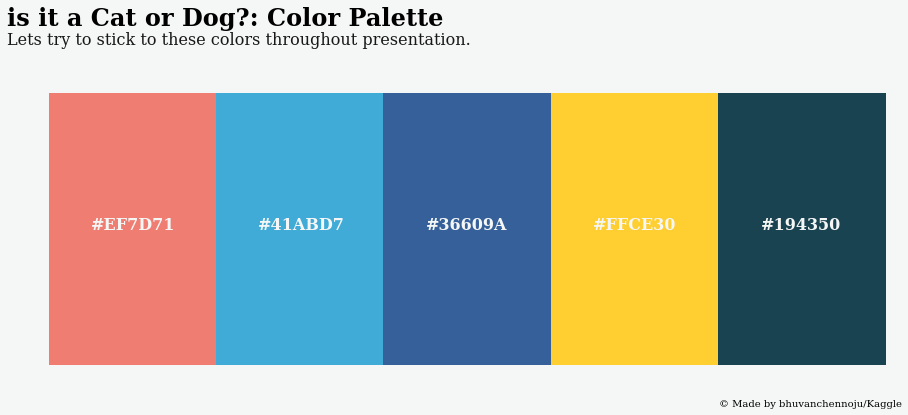

In [5]:
# color palette
colors = ['#EF7D71','#41ABD7','#36609A','#FFCE30','#194350']
sns.palplot(colors,size = 3)

plt.gcf().set_size_inches(15,5)

plt.text(-0.75,-0.75, 'is it a Cat or Dog?: Color Palette',{'fontfamily':'serif', 'size':24, 'weight':'bold'})
plt.text(-0.75,-0.68, 'Lets try to stick to these colors throughout presentation.',{'fontfamily':'serif', 'size':16},alpha = 0.9)
for idx,values in enumerate(colors):
    plt.text(idx-0.25,0, colors[idx],{'fontfamily':'serif', 'size':16, 'weight':'bold','color':'#f5f6f6'}, alpha =1)
plt.gcf().set_facecolor('#f5f6f6')
plt.box(None)
plt.axis('off')
plt.text(3.5,0.65,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.show()

## **Lets Extract Labels from Image Names...**

In [6]:
# extraction of train and test data from zipfiles to data folder
print('\n'+color.BOLD_COLOR + 'Extracting the data from dataset.....'+ color.END +'\n')
zip_files = glob.glob(f'{dataDir}/*.zip')

print('{} files found in the input directory'.format(color.BOLD + str(len(zip_files)) + color.END) +'\n')
for file in zip_files:
    with zipfile.ZipFile(file, 'r') as Z:
        Z.extractall(f'{dataDir}/')
    print ('{} is extracted'.format(color.BOLD + file.split('/')[-1] + color.END) + '\n')
      
print( color.BOLD_COLOR +'Extraction is completed'+ color.END +'\n')


Extracting the data from dataset.....

2 files found in the input directory

test1.zip is extracted

train.zip is extracted

Extraction is completed



In [7]:
# Total number of images in train and test datasets

train_dir = f'{dataDir}/train/'
test_dir  = f'{dataDir}/test1/'
print(color.BOLD +"Total Images in Train, and Test Data..." +color.END)
print('\n' + color.BOLD_COLOR + 'No. of Train Images: '+ color.END + color.BOLD + str(len(os.listdir(train_dir))) + color.END)
print( color.BOLD_COLOR + 'No. of Test Images: ' + color.END + color.BOLD + str(len(os.listdir(test_dir))) + color.END + '\n')        


Total Images in Train, and Test Data...

No. of Train Images: 25000
No. of Test Images: 12500



In [8]:
# category and filepath extraction helper functions

def category(path): 
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

# image names and labels
x_train_imgname = filename(train_dir) 
x_test_imgname = filename(test_dir)
y_train_label = category(train_dir)

#creation of total dataframe and submission dataframe
print( '\n'+color.BOLD + 'Image data is storing into dataframes...'+ color.END + '\n')
train_image_df = pd.DataFrame({ 'filename': x_train_imgname, 'category': y_train_label})
submission_image_df = pd.DataFrame({'filename': x_test_imgname})

print(color.BOLD +'Training image names and labels are read to '+ color.END + color.BOLD_COLOR +'train_image_df' + color.END + '\n')
print(color.BOLD +'Testing image names are read to '+ color.END + color.BOLD_COLOR + 'submission_image_df'+ color.END + '\n')


Image data is storing into dataframes...

Training image names and labels are read to train_image_df

Testing image names are read to submission_image_df



# **Data visualization**

## **Lets write helper funtions for path extraction and visualization of training images...**

In [9]:
print(color.BOLD +'\n'+'Helper funtions for image path,id, category data extractions and Image visualizations' +'\n'+color.END)
# helper functions 

def img_path(directory):
    ''' 
    This function extracts image ids, category,and image paths from directory.
    input:
    directiory: Path to location of images
    Return:
    ID_no: list of image ids
    Paths: list of image paths
    cate: list of category
    '''
    paths = []
    cate = []
    ID_no = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        paths.append(path)
        cate.append(file.split('.')[0])
        ID_no.append(file.split('.')[1])
    return ID_no, paths, cate




def showImages(data,num_row  = 3,num_col =  3, name = 'any', subtitle = 'off'):
    """ This function creates a grid of images from  dataset.
    Shuffled images will be displayed.
    
    Input: 
    num_row: default: 3, no. of rows in a grid
    num_col: default:3, no. of columns in grid
    data: Dataframe of paths 
    name:  default 'any', takes: cat, dog, any or something else would give both
    subtitle: display id number for each image, defalult: 'off', takes: 'on' and 'off'
    Return: None
    
    """
    
    # little data sorting
    cat_df,dog_df = data[data['Category'] == 'cat'], data[data['Category'] == 'dog']

    
    if name == 'dog':
        X, Y  = dog_df['img_paths'], dog_df['ID_no']
    elif name == 'cat':
        X, Y  = cat_df['img_paths'], cat_df['ID_no']     
    else:
        X, Y  = data['img_paths'], data['ID_no']     # could use try and except but lets stick to minimal code

    (X_rand, Y_rand) = shuffle(X, Y)
    
    # showing images on matplotlib 
    
    fig, ax = plt.subplots(num_row,num_col,figsize = (12,12), dpi = 100)
    fig.patch.set_facecolor('#f5f6f6')
    axes = ax.ravel()
    
    for idx,ax  in enumerate(axes):
        x = load_img(X_rand.iloc[idx],target_size= (125, 125))
        ax.imshow(x)
        if subtitle == 'on':
            ax.set_title("{}".format(Y_rand.iloc[idx]))
        else:
            ax.set_title('')
        ax.axis('off')
        plt.subplots_adjust(wspace =0)
        del x
    #fig.tight_layout()
    
    fig.text(0.1,0.93, 'is it a Cat or Dog?: {}s from Training Data'.format(name.capitalize()),{'fontfamily':'serif','size':18,'weight':'bold'})
    
    return None


Helper funtions for image path,id, category data extractions and Image visualizations



In [10]:
# Implementing above function over train data set
ID_no, img_paths, train_images = img_path(train_dir)

print('\n'+color.BOLD_COLOR + 'Dataframe is creating for training image visualization in a grid...' + color.END+'\n' )
#creating new dataframe for data visulaization

visual_df = pd.DataFrame({'ID_no':ID_no,'Category':train_images, 'img_paths': img_paths})

print(color.BOLD );print(visual_df.head(5))

print('\n'+color.BOLD_COLOR +'Done!'+color.END + '\n')


Dataframe is creating for training image visualization in a grid...


   ID_no Category                          img_paths
0   1448      dog   /content/data/train/dog.1448.jpg
1   6140      cat   /content/data/train/cat.6140.jpg
2   7039      dog   /content/data/train/dog.7039.jpg
3   5395      cat   /content/data/train/cat.5395.jpg
4  10994      cat  /content/data/train/cat.10994.jpg

Done!



## **Lets see the images from training images...**

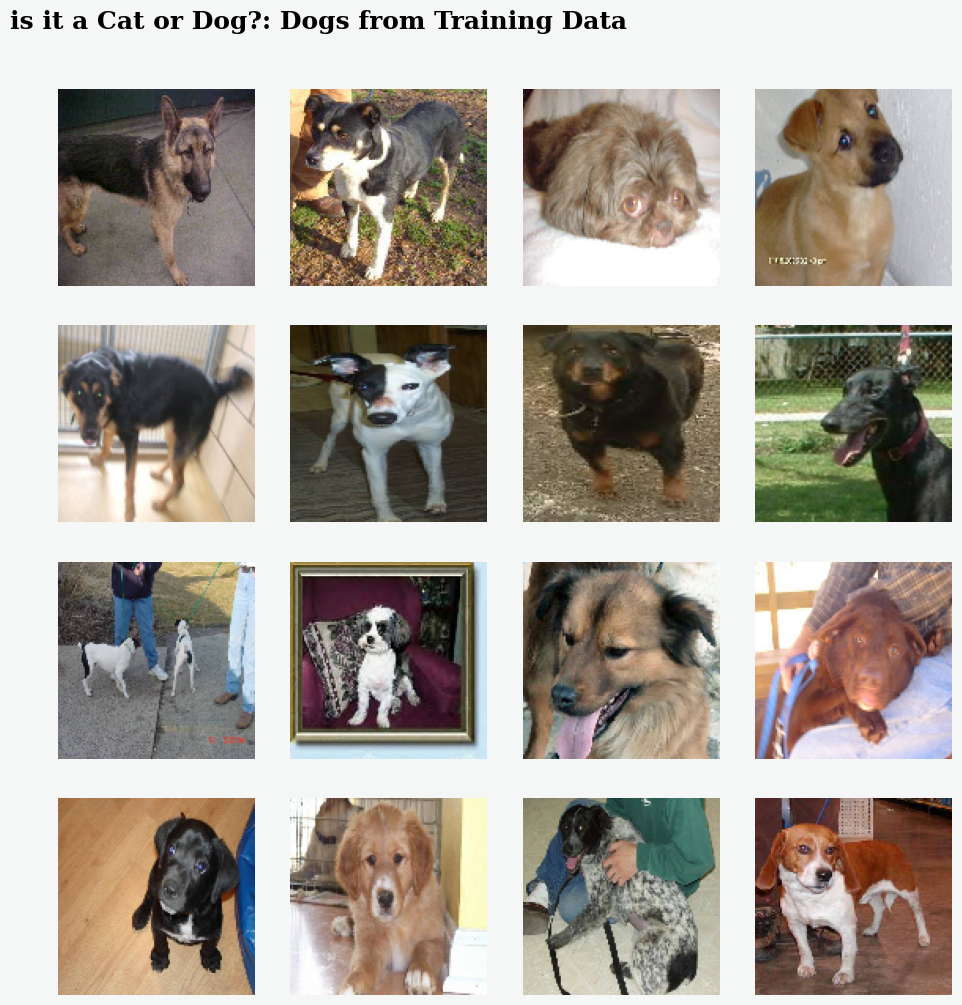

In [11]:
showImages(visual_df,4,4, name = 'dog', subtitle = 'off')

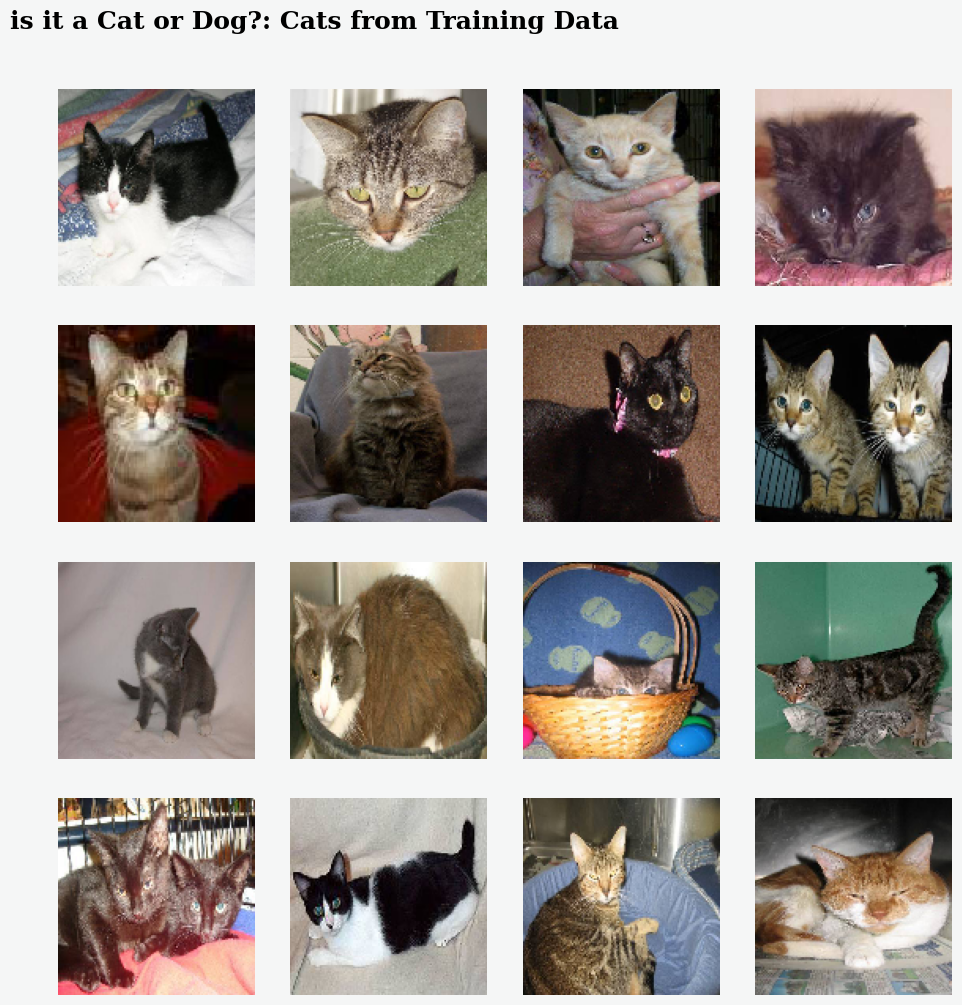

In [12]:
showImages(visual_df,4,4, name = 'cat', subtitle = 'off')

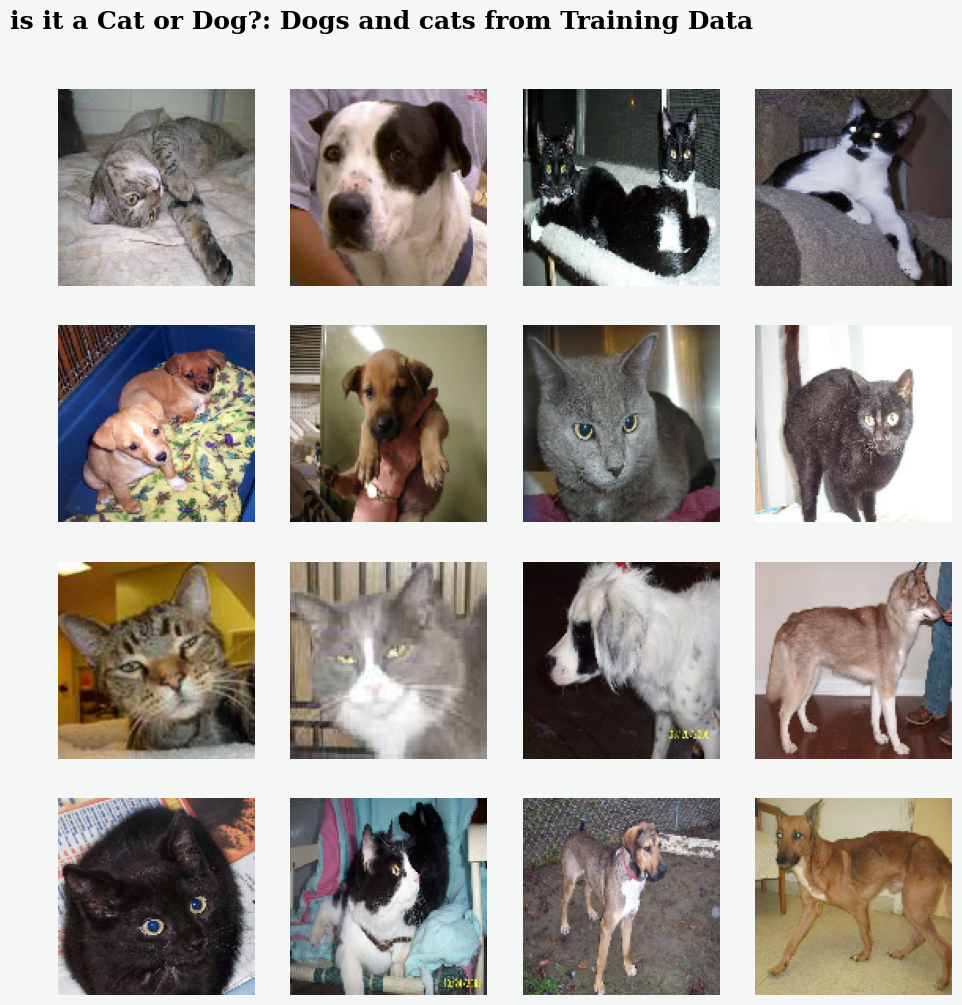

In [13]:
showImages(visual_df,4,4, name = 'Dogs and Cat', subtitle = 'off')

## **Lets split data into training and validation dataset, and visualize the data distribution...**

In [14]:
# Data split into train data and validation data
train_valid_df, test_df = train_test_split(train_image_df, test_size = 0.04)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2)

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
holdon_images = test_df.shape[0]
test_images = submission_image_df.shape[0]

print('\n'+color.BOLD_COLOR + 'Number of Training Images: ' + color.END + color.BOLD+ str(train_images)+ color.END)
print('\n'+color.BOLD_COLOR +  'Number of Validating Images: ' + color.END + color.BOLD+ str(valid_images)+ color.END)
print( '\n'+color.BOLD_COLOR +  'Number of Holdon Images: ' + color.END +  color.BOLD+ str(holdon_images)+ color.END)
print('\n'+color.BOLD_COLOR + 'Number of Testing Images: ' + color.END +  color.BOLD+str(test_images)+ color.END)


Number of Training Images: 19200

Number of Validating Images: 4800

Number of Holdon Images: 1000

Number of Testing Images: 12500


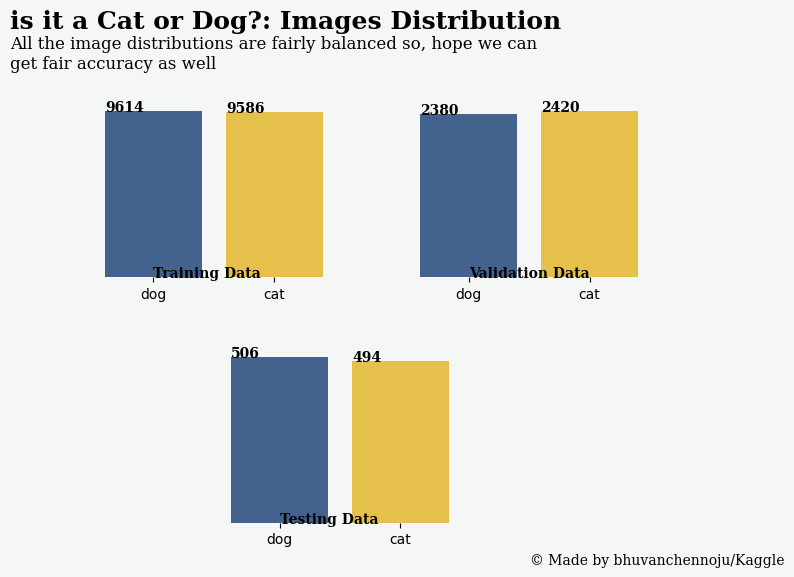

In [15]:
fig = plt.figure(figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')
gs = fig.add_gridspec(10,10)

ax0 = fig.add_subplot(gs[2:5,1:5])
ax1 = fig.add_subplot(gs[2:5,6:10])
ax2 = fig.add_subplot(gs[6:9,3:7])


axes = [ax0,ax1,ax2]
data  = [train_df['category'] ,  valid_df['category'], test_df['category']]
labels = ['Training Data','Validation Data','Testing Data']

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.axes.get_yaxis().set_visible(False)
    
    for loc in ['left','right','top','bottom']:
        ax.spines[loc].set_visible(False)
    
for ax,df, label in zip(axes,data,labels):
    sns.countplot(df, ax = ax, palette = [colors[2],colors[3]], alpha =1)
    ax.set_xlabel(xlabel = ' ')
    for pa in ax.patches: 
        ax.text(pa.get_x(), pa.get_height(),'{}'.format(pa.get_height()), **{'fontfamily':'serif', 'size':10, 'weight':'bold'}, alpha = 1)

    ax.text(0,0,label,**{'fontfamily':'serif', 'size':10, 'weight':'bold'})

fig.text(0.1,0.82, 'is it a Cat or Dog?: Images Distribution',{'fontfamily':'serif','size':18,'weight':'bold'})
fig.text(0.1,0.77, '''All the image distributions are fairly balanced so, hope we can
get fair accuracy as well''',{'fontfamily':'serif','size':12,})

fig.text(0.75,0.15,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
fig.show()


# **Classification with Vanilla CNN**

## **Let's prepared training, validation, testing data for vanilla CNN without any agumentations...**

In [16]:
img_size = 224
batch_size = 128

print(color.BOLD_COLOR + '\nPreparing train and validation images for training...' + color.END)
# dataframe iterators without data agumnetation

train_map = ImageDataGenerator()
valid_map = ImageDataGenerator()
test_map =  ImageDataGenerator()

print(color.BOLD)
        
#Creatinga a dataframe iterators for fitting
vani_train_data = train_map.flow_from_dataframe(
            train_df,train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')

vani_valid_data = valid_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')


vani_test_data = test_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = None,
             shuffle = False)

print(color.BOLD_COLOR + '\nDone!')


Preparing train and validation images for training...

Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.

Done!


## **Lets build vanila CNN model ...**

In [17]:
#Building model computational graph
vani_model = Sequential()
vani_model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,3)))
vani_model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

vani_model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

vani_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Dropout(0.3))

vani_model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Dropout(0.3))

vani_model.add(Flatten())

vani_model.add(Dense(512, activation = 'relu'))

vani_model.add(Dropout(0.5))

vani_model.add(Dense(2, activation = 'softmax'))

print(color.BOLD_COLOR + '\nVanilla Model layers and output shapes with params...\n'+color.END)

print(color.BOLD)
vani_model.summary()


Vanilla Model layers and output shapes with params...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________

## **Lets See vanila CNN model Schematic diagram ...**

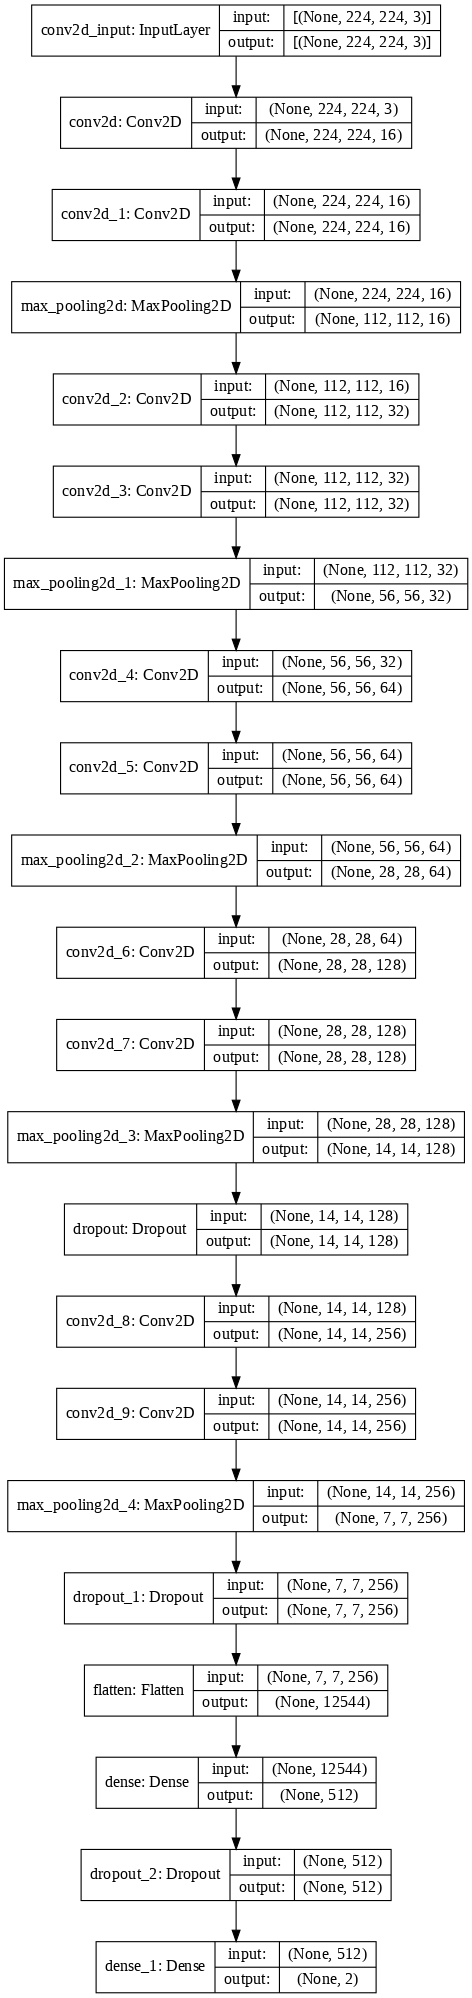

In [18]:
plot_model(vani_model, show_shapes = True,expand_nested = True,dpi = 80)
#SVG(model_to_dot(vani_model).create(prog='dot', format='svg'))

## **Lets train and validate on vanila CNN model ...**

In [19]:
#compiling model with loss, opt, metrics
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)
metrics = ['accuracy']

vani_model.compile(loss = loss, optimizer = opt, metrics = metrics)

print(color.BOLD_COLOR + 'Training on Vanilla CNN has started ....\n'+ color.END)
print(color.BOLD)
# fitting the model for training dataset
vani_history = vani_model.fit(vani_train_data, epochs = 15,
                          validation_data = vani_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size)

print(color.END)
print(color.BOLD_COLOR + '\nDone!\n'+ color.END)


Training on Vanilla CNN has started ....


Epoch 1/15
150/150 [==============================] - 146s 727ms/step - loss: 0.9890 - accuracy: 0.5481 - val_loss: 0.6495 - val_accuracy: 0.6037
Epoch 2/15
150/150 [==============================] - 110s 729ms/step - loss: 0.6111 - accuracy: 0.6544 - val_loss: 0.5858 - val_accuracy: 0.6742
Epoch 3/15
150/150 [==============================] - 109s 724ms/step - loss: 0.5520 - accuracy: 0.7117 - val_loss: 0.5394 - val_accuracy: 0.7179
Epoch 4/15
150/150 [==============================] - 108s 716ms/step - loss: 0.5148 - accuracy: 0.7431 - val_loss: 0.5522 - val_accuracy: 0.7014
Epoch 5/15
150/150 [==============================] - 106s 703ms/step - loss: 0.4760 - accuracy: 0.7708 - val_loss: 0.4990 - val_accuracy: 0.7572
Epoch 6/15
150/150 [==============================] - 106s 702ms/step - loss: 0.4389 - accuracy: 0.7961 - val_loss: 0.4504 - val_accuracy: 0.7924
Epoch 7/15
150/150 [==============================] - 105s 697ms/step - loss: 0.4

## **Lets plot vanila CNN model change in loss and accuracys with epochs ...**

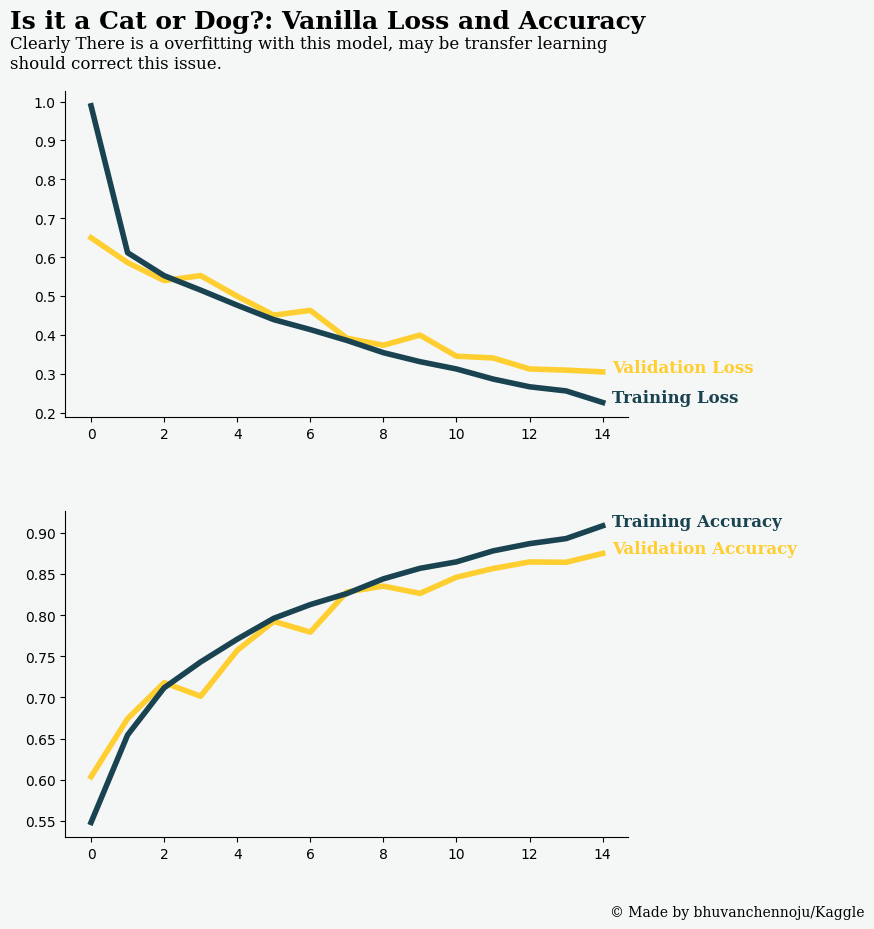

In [21]:
fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)
        
hist1 = vani_history.history
Epochs =  range(len(hist1['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist1['val_loss'],  ax = axes[0], linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist1['loss'], ax  = axes[0], linewidth =4,  color = colors[4])


axes[0].text(Epochs[-1]+0.25,hist1['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[0].text(Epochs[-1]+0.25,hist1['loss'][-1] ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


# accuracy plot
sns.lineplot(x = Epochs, y = hist1['val_accuracy'],ax = axes[1],linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist1['accuracy'],ax = axes[1],linewidth =4,  color = colors[4])
axes[1].text(Epochs[-1]+0.25,hist1['val_accuracy'][-1],'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[1].text(Epochs[-1]+0.25,hist1['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


fig.text(0,1.06, 'Is it a Cat or Dog?: Vanilla Loss and Accuracy ',{'fontfamily':'serif', 'size':18, 'weight':'bold'})
fig.text(0,1.01, '''Clearly There is a overfitting with this model, may be transfer learning
should correct this issue.''',{'fontfamily':'serif', 'size':12})
        
fig.text(0.75,-0.05,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.tight_layout(h_pad = 5)

## **Lets see vanila CNN predictions with confusion matrix ...**

In [22]:
vani_pred = vani_model.predict_generator(vani_test_data)
test_df['vani_pred'] = np.argmax(vani_pred, axis = -1)
labels = dict((v,k) for k,v in vani_train_data.class_indices.items())

test_df['vani_pred'] = test_df['vani_pred'].map(labels)

In [23]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('#f5f6f6')
    sns.heatmap(cf,annot=box_labels,fmt="",linewidths = 1,square = True,linecolor= '#f5f6f6',
                cmap=cmap,cbar=cbar,annot_kws={'fontfamily':'serif','size':18,'weight':'bold'},
                xticklabels=categories,
                yticklabels=categories,)

    if xyplotlabels:
        plt.ylabel('True label', **{'fontfamily':'serif','size':12,'weight':'bold'})
        plt.xlabel('Predicted label' + stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    else:
        plt.xlabel(stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    
    plt.gca().set_xticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})
    plt.gca().set_yticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})


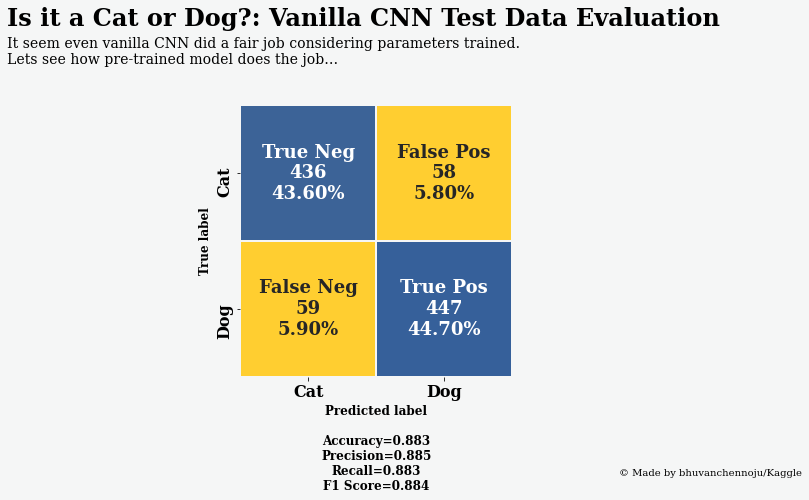

In [24]:
vani_cf_matrix = confusion_matrix(test_df['category'],test_df['vani_pred'])
my_cols = [colors[3],colors[2]]

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(vani_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",my_cols),
                      categories=categories, 
                      title = 'Vanila CNN comfusion matrix')

plt.gcf().text(0,1.1,'Is it a Cat or Dog?: Vanilla CNN Test Data Evaluation',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.995,"""It seem even vanilla CNN did a fair job considering parameters trained.
Lets see how pre-trained model does the job...""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().text(0.85,-0.15,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()


In [25]:
#save model
vani_model.save("/content/drive/MyDrive/tmp/vani_model_v1.h5")

# **Data Agumentation, Early Stopping, Learning Rate Schedule**

## **Lets code helper function for visualization of image agumentation...**

In [28]:
print(color.BOLD +'\n'+'Helper funtions for Image Agumentation visualizations' +'\n'+color.END)

def data_argumentation_show(n, grid_size):
    sample_aug_map = ImageDataGenerator(
            #zoom_range = 0.1,
            rotation_range = 25,
            horizontal_flip = True,
            height_shift_range =0.2,
            width_shift_range = 0.2,
            fill_mode='nearest',
            rescale = 1/255)
    sample_data = sample_aug_map.flow_from_dataframe(
            (train_df.sample(n)),
            train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()

     
    fig.text(0.1,0.93, 'Is it cat or dog?: Image agumentation',{'fontfamily':'serif','size':20,'weight':'bold'})
    
    return None



Helper funtions for Image Agumentation visualizations



Found 1 validated image filenames belonging to 1 classes.


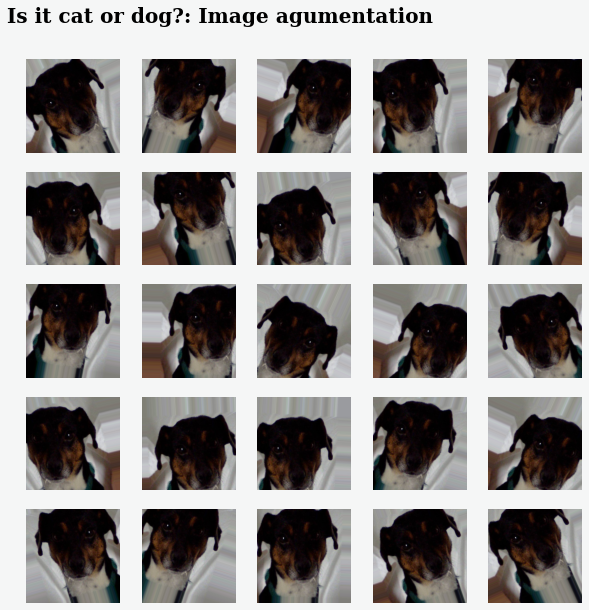

In [30]:
# To visulalize the effect of data argumentation 
#select number of samples to argument----> n = 
# total number of argumentation is grid_Size**2

data_argumentation_show(1, 5)

Found 2 validated image filenames belonging to 2 classes.


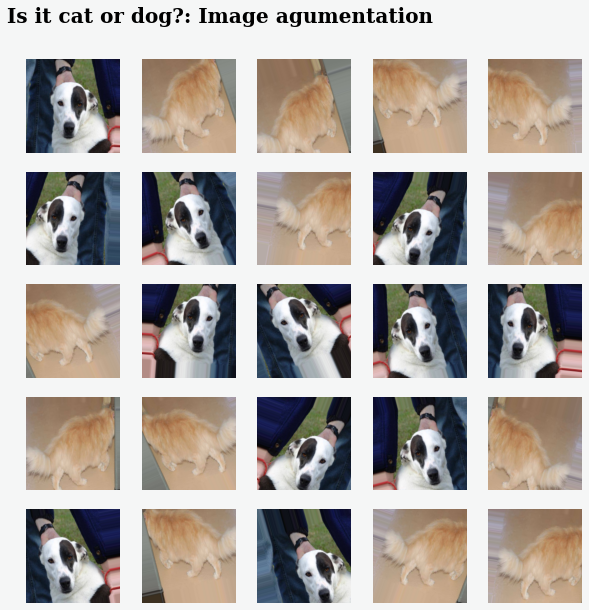

In [32]:
data_argumentation_show(2, 5)

## **Decaying learing rate setting function...**

In [33]:
print(color.BOLD + '\nSetting a decay learning rate for learning rate schedule\n'+ color.END)
epoch = 50
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr
    
print(color.BOLD_COLOR + 'Done!' +color.END)


Setting a decay learning rate for learning rate schedule

Done!


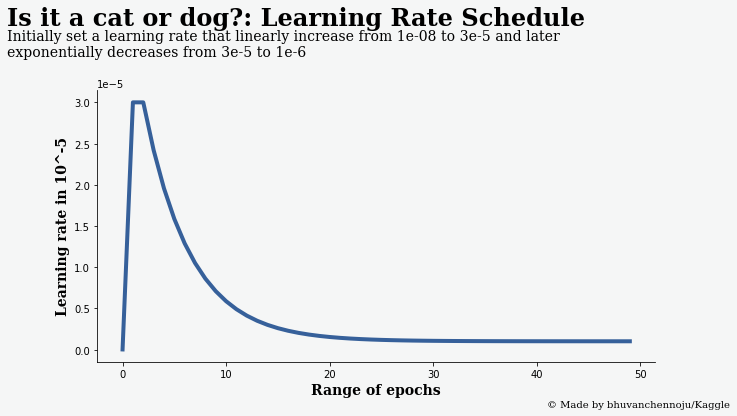

In [34]:
epochs = 20
epochs_range = [i for i in range(50 if epochs<50 else epochs)]
learn_rate = [lrfn(x) for x in epochs_range]


fig,ax = plt.subplots(figsize = (10,5))
fig.patch.set_facecolor('#f5f6f6')
ax.set_facecolor('#f5f6f6')

for loc in ['right','top',]:
    ax.spines[loc].set_visible(False)

ax.plot(epochs_range, learn_rate, linewidth = 4, color= colors[2]) 
plt.xlabel('Range of epochs',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})
plt.ylabel('Learning rate in 10^-5',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})


plt.gcf().text(0,1.06,'Is it a cat or dog?: Learning Rate Schedule',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.975,"""Initially set a learning rate that linearly increase from 1e-08 to 3e-5 and later
exponentially decreases from 3e-5 to 1e-6""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().text(0.75,0,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()

# **Classification with ResNet50**

## **Image agumentation data preparation with ImageDataGenerator**

In [37]:
print(color.BOLD_COLOR + '\n Agumenting Train, Validation images... and testing images just passing through... \n'+ color.END)

print(color.BOLD)
# using standard data augumentation

train_aug_map = ImageDataGenerator(
                    rotation_range=10,
                    #zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    #width_shift_range=0.1,
                    #height_shift_range=0.1,
                    preprocessing_function = imagenet_utils.preprocess_input)
res_train_data = train_aug_map.flow_from_dataframe(
            train_df, train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')

#one should validate the generality of model on the actcual target images
#so not supposed agumentation
valid_aug_map = ImageDataGenerator(preprocessing_function = imagenet_utils.preprocess_input)

res_valid_data = valid_aug_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')


#test data rescaling images

test_aug_map = ImageDataGenerator(preprocessing_function = imagenet_utils.preprocess_input)

res_test_data = test_aug_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)



 Agumenting Train, Validation images... and testing images just passing through... 


Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


## **Building model for transfer learning on top of pretrained ResNet50 Model...**

In [39]:
#loading resent 
resNet = tf.keras.applications.ResNet50(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224,224, 3))

resNet.trainable = False # Freeze layers
resNet_model = Sequential([
        resNet,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.4),
        Dense(2, activation = 'softmax')])
     

optimizer = optimizers.adam_v2.Adam(1e-5)

print(color.BOLD_COLOR + '\nResNet based Transfer learning Model layers and output shapes with params...\n'+color.END)

print(color.BOLD)
resNet_model.summary()
#plot_model(resNet_model, to_file='resNet_model.png')


ResNet based Transfer learning Model layers and output shapes with params...


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2050      
Total params: 126,351,234
Trainable params: 102,763,522
Non-trainable params: 23,587,712
_________________________________________________________________


In [40]:
print(color.BOLD + '\nSetting early stopping factor and learning rate schedule\n' +color.END)

earlystop = EarlyStopping(patience= 5)
    
lr_callback = LearningRateScheduler(lrfn, verbose = True)

callbacks = [earlystop, lr_callback]
print(color.BOLD_COLOR + 'Done!')


Setting early stopping factor and learning rate schedule

Done!


## **Lets train and validate Pre-trained ResNet50 model for top layers...**

In [41]:
resNet_model.compile(optimizer = optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

print(color.BOLD_COLOR + 'Training on ResNet50 has started ....\n'+ color.END)
print(color.BOLD)

resnet_history = resNet_model.fit_generator(res_train_data, epochs = 15,
                          validation_data = res_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size,
                          callbacks = callbacks)
print(color.END)
print(color.BOLD_COLOR + 'Done!\n'+ color.END)

Training on ResNet50 has started ....


Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 1e-08.
150/150 [==============================] - 335s 2s/step - loss: 2.0340 - accuracy: 0.4519 - val_loss: 1.5379 - val_accuracy: 0.4371
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 3e-05.
150/150 [==============================] - 330s 2s/step - loss: 0.2257 - accuracy: 0.9686 - val_loss: 0.1267 - val_accuracy: 0.9812
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 3e-05.
150/150 [==============================] - 330s 2s/step - loss: 0.0465 - accuracy: 0.9881 - val_loss: 0.0643 - val_accuracy: 0.9867
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
150/150 [==============================] - 330s 2s/step - loss: 0.0271 - accuracy: 0.9917 - val_loss: 0.0498 - val_accuracy: 0.9878
Epoch 5/15

Epoch 00005: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
150

In [42]:
#save model
resNet_model.save("/content/drive/MyDrive/tmp/resNet_model_v1.h5")

## **Lets plot Resnet models change in loss and accuracys with epochs ...**

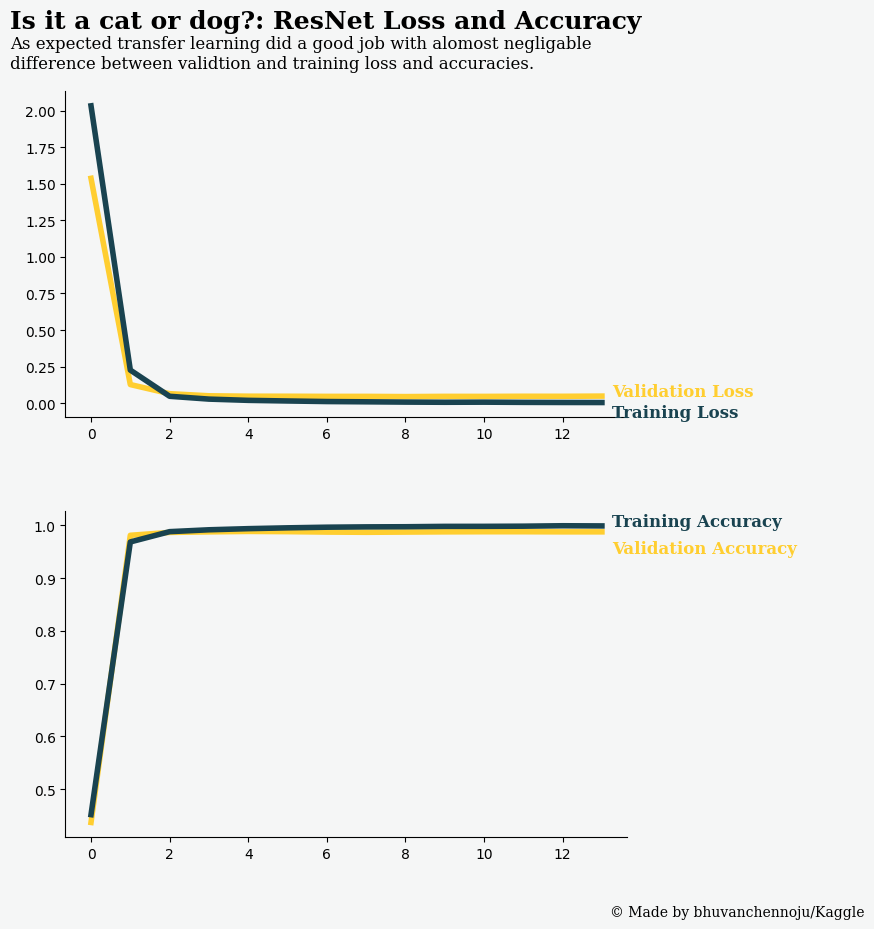

In [43]:
fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)
        
hist2 = resnet_history.history
Epochs =  range(len(hist2['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist2['val_loss'],  ax = axes[0], linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist2['loss'], ax  = axes[0], linewidth =4,  color = colors[4])


axes[0].text(Epochs[-1]+0.25,hist2['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[0].text(Epochs[-1]+0.25,hist2['loss'][-1]-0.1 ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


# accuracy plot
sns.lineplot(x = Epochs, y = hist2['val_accuracy'],ax = axes[1],linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist2['accuracy'],ax = axes[1],linewidth =4,  color = colors[4])
axes[1].text(Epochs[-1]+0.25,hist2['val_accuracy'][-1]-0.04,'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[1].text(Epochs[-1]+0.25,hist2['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


fig.text(0,1.06, 'Is it a cat or dog?: ResNet Loss and Accuracy ',{'fontfamily':'serif', 'size':18, 'weight':'bold'})
fig.text(0,1.01, '''As expected transfer learning did a good job with alomost negligable
difference between validtion and training loss and accuracies.''',{'fontfamily':'serif', 'size':12})
fig.text(0.75,-0.05,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
        
plt.tight_layout(h_pad = 5)

fig.show()


## **Lets see ResNet predictions with confusion matrix ...**

In [44]:
res_pred = resNet_model.predict_generator(res_test_data)
test_df['res_pred'] = np.argmax(res_pred, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())

test_df['res_pred'] = test_df['res_pred'].map(labels)

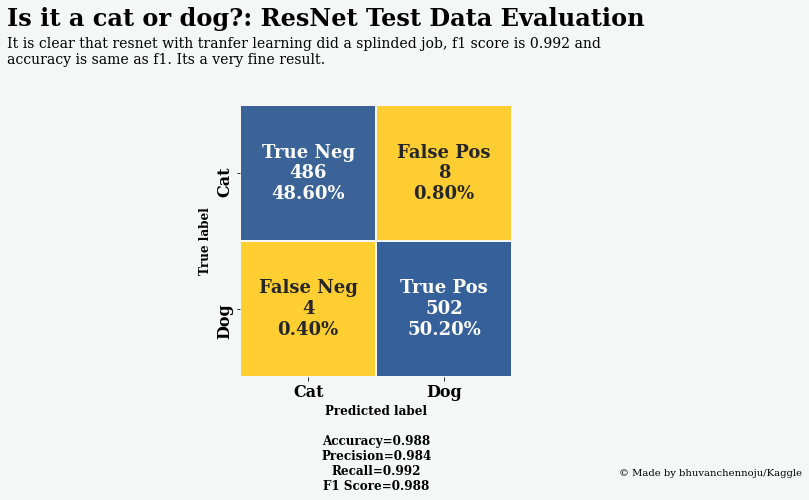

In [45]:
res_cf_matrix = confusion_matrix(test_df['category'],test_df['res_pred'])
my_cols = [colors[3],colors[2]]

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(res_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",my_cols),
                      categories=categories, 
                      title = 'Vanila CNN comfusion matrix')

plt.gcf().text(0,1.1,'Is it a cat or dog?: ResNet Test Data Evaluation',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.995,"""It is clear that resnet with tranfer learning did a splinded job, f1 score is 0.992 and 
accuracy is same as f1. Its a very fine result.""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().text(0.85,-0.15,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()


# **Final predictions on Test Set**

In [47]:
print(color.BOLD_COLOR + '\n Final test data preperation for both vanilla and resnet for final predictions \n'+ color.END)
# generating an dataframe iterator for test dataset

print(color.BOLD)
vani_sub_aug_map = ImageDataGenerator()
res_sub_aug_map = ImageDataGenerator(preprocessing_function = imagenet_utils.preprocess_input)

vani_sub_data = vani_sub_aug_map.flow_from_dataframe(
             submission_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)


res_sub_data = res_sub_aug_map.flow_from_dataframe(
             submission_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)



 Final test data preperation for both vanilla and resnet for final predictions 


Found 12500 validated image filenames.
Found 12500 validated image filenames.


In [48]:
print(color.BOLD_COLOR + '\n Making final predictions with both resnet and vanilla cnns for Test data'+color.END)
vani_pred_sub = vani_model.predict_generator(vani_sub_data)
submission_image_df['vani_pred_sub'] = np.argmax(vani_pred_sub, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())
submission_image_df['vani_pred_sub'] = submission_image_df['vani_pred_sub'].map(labels)


res_pred_sub = resNet_model.predict_generator(res_sub_data)
submission_image_df['res_pred_sub'] = np.argmax(res_pred_sub, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())
submission_image_df['res_pred_sub'] = submission_image_df['res_pred_sub'].map(labels)

print(color.BOLD)
print(submission_image_df.head())


 Making final predictions with both resnet and vanilla cnns for Test data

   filename vani_pred_sub res_pred_sub
0  4488.jpg           cat          cat
1   980.jpg           dog          dog
2  7051.jpg           dog          dog
3  9954.jpg           dog          dog
4  1585.jpg           cat          cat


## **Lets see how our predictions are done on Test Data by both networks...**

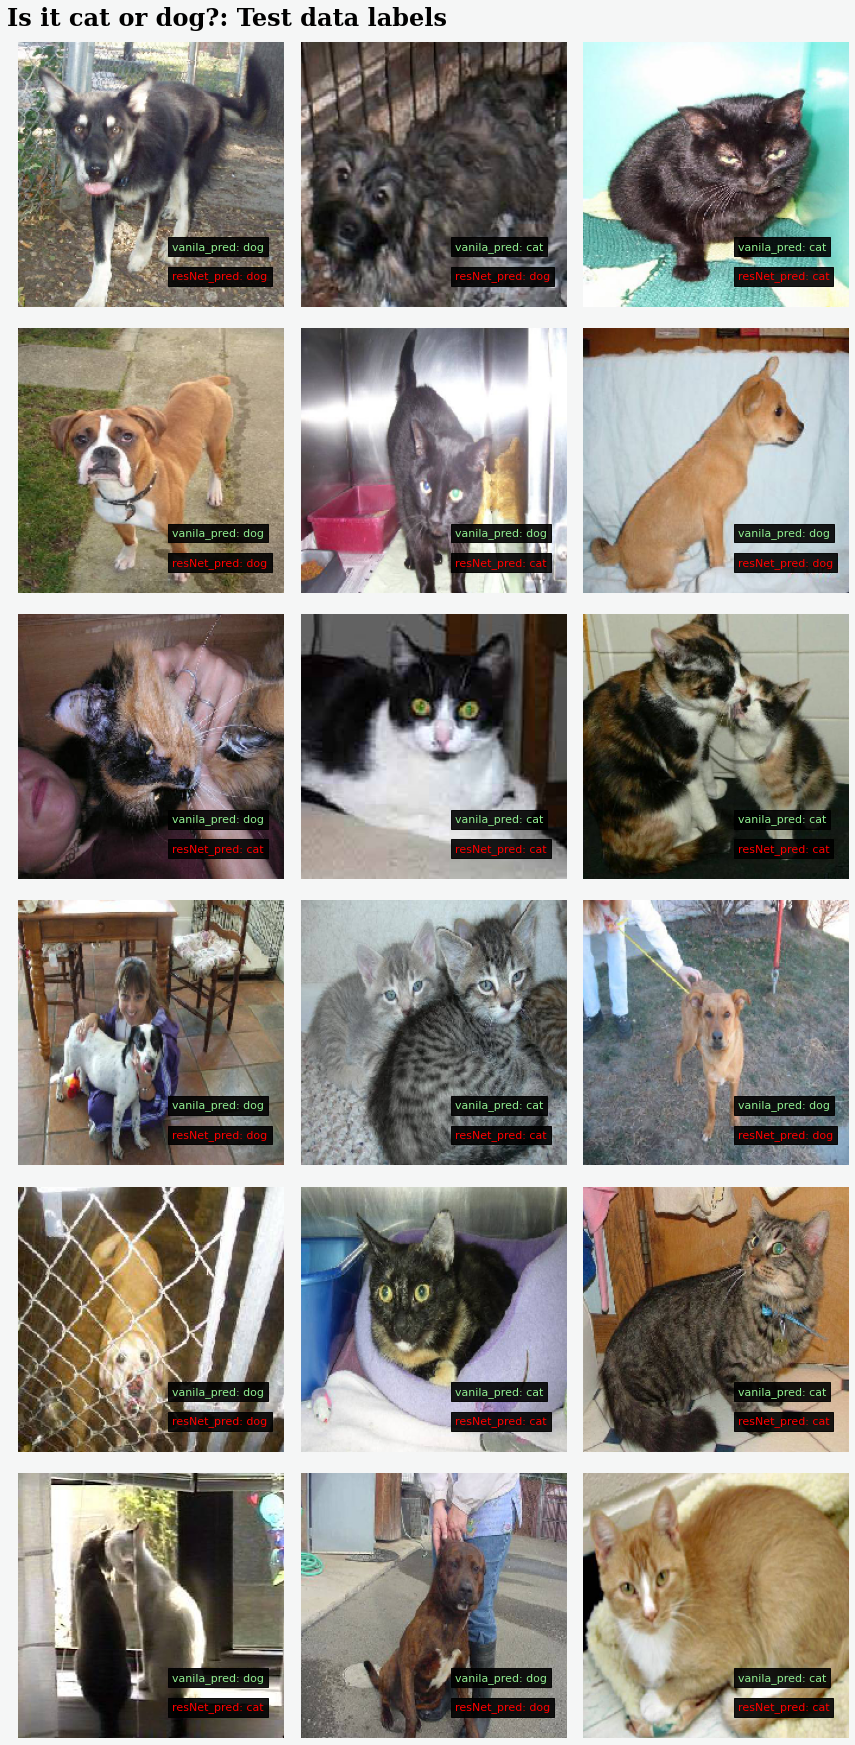

In [50]:
pred_sample = submission_image_df.sample(18)
pred_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('#f5f6f6')

for index, row in pred_sample.iterrows():
    filename = row['filename']
    vani_pred = row['vani_pred_sub']
    res_pred = row['res_pred_sub']
    img = load_img( test_dir + filename, target_size= (img_size, img_size))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(130, 175, 'vanila_pred: {}'.format(vani_pred), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(130, 200, 'resNet_pred: {}'.format(res_pred), color='red',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    #plt.title(filename.split('.')[0])
    del img
plt.tight_layout()
#plt.subplots_adjust( wspace=0, hspace= 1)
fig.text(0,1, 'Is it cat or dog?: Test data labels',{'fontfamily':'serif','size':24,'weight':'bold'})
fig.show()
